In [2]:
from imp import reload
import sys
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
import runner
import umm

## Running UMM experiments

MANU: But this seems to also run CEGO? 

In [ ]:
reload(runner)
instance_name="LOP-synthetic,seed=123456,n=20,m=200,phi=0.9"
# instance_name="pfsp/rec19.txt"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="qap/nug12.dat"
budgetGA=5 # ???? But this should be 10**3
seed=2
budget=200 ## ??? This sould be 400
m_ini=10
budgetMM=10 ### ????
# ratio_samples_learn=0.10
# weight_mass_learn=0.9
res = []
np.set_printoptions(linewidth=np.nan) # MANU: Should we move this to the top cell?
for ratio_samples_learn in [.1]:
  for weight_mass_learn in [0.9]:
    out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
    df = runner.run_once("uMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
                         ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename)
    res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
    print("best found",df.Fitness.min())
    #out_filename="local_new_CEGO"
    #runner.run_once("CEGO", instance_name, seed,budget = budget, m_ini = m_ini, budgetGA = budgetGA, out_filename = out_filename)

## Plots ???

In [ ]:
# instance_name="pfsp/rec05.txt"
out_file = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
df = pd.read_pickle(out_filename+'.pkl.gz')
#dfc, dfu = pd.read_pickle('local_new_CEGO.pkl.gz'),pd.read_pickle('local_new_uMM.pkl.gz');df = pd.concat([dfc, dfu]) 

print("instance name", df.instance.iloc[0], "- time", round(df.run_time.iloc[0], 2))
sns.set_style("whitegrid")
print(df.Fitness.min())
# 'pickles/pickLocal.pkl')#pick570618.pkl

color_variable = 'Solver'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(15,5))
    sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
    plt.show()

# Real data umm

we have executed umm with a grid of parameters ratio_samples_learn & weight_samples_learn. We load the min found in the execution in `df` and the best known solutions in `best`. (The best know for the real data LOP are give as a maximitaion problem so this value has to be corrected)



### What is this doing?

In [ ]:
find_in_lop_folder('N-be75eec', ret_value='path'),find_in_lop_folder('N-be75eec_150', ret_value='path')

### Aren't these functions already in some .py file that we load?

In [ ]:


def find_in_lop_folder(instance_name, ret_value='instance'):
  import os
  for fol in os.listdir("lop"):
    if os.path.isdir("lop/"+fol):
      for file in os.listdir("lop/"+fol):
          if instance_name == file:
              path = "lop/"+fol+"/"+file
              with open(path) as f:
                n = int(f.readline().strip())
                instance = np.loadtxt(f, max_rows=n)
              if ret_value == 'instance' : return instance
              if ret_value == 'path': return path
  return None
#find_in_lop_folder('N-t1d100.01')

def get_best_known():
  best = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
## maximizar la de abajo o minimizar la de arriba, el plateamiento es distint, hay q ajustar los datos que nos dan del best_fval
  # cambia los de la carperta LOP 
  for instance_name in best.instance_name:
    inst = find_in_lop_folder(instance_name)
    if inst is not None:
      ins, be = inst.sum() , best[best.instance_name==instance_name].best_known_global.values[0] 
  #     print(ins, be)
      best.loc[best.instance_name==instance_name, 'best_known_global'] = ins - be 
  return best



## which ratio_samples_learn & weight_samples_learn is the best for each instance?

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

Overall, we can say that `ratio_samples_learn=0.1` and `weight_samples_learn=0.9` is a reasonable choice

N-atp111


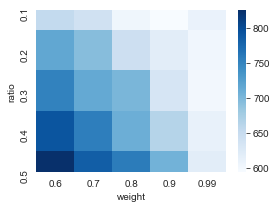

N-atp134


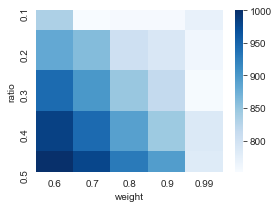

N-be75eec-150


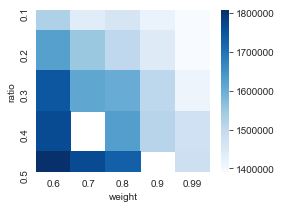

N-be75np-150


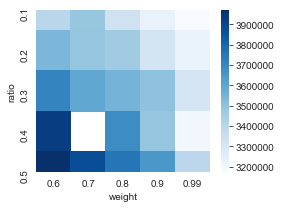

N-p50-01


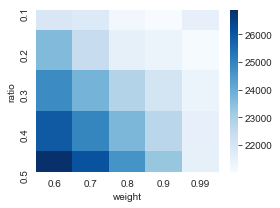

N-p50-02


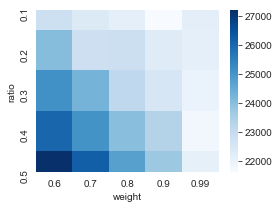

N-t1d100.01


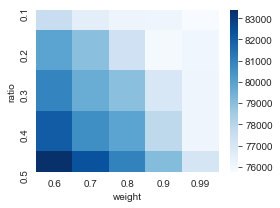

N-t1d100.02


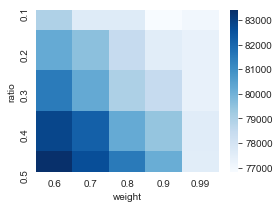

N-t1d150.01


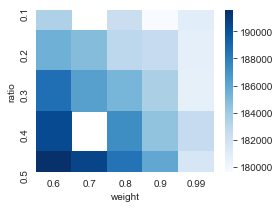

N-t1d150.02


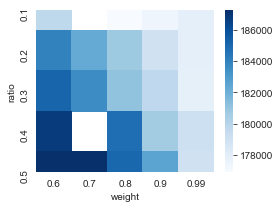

N-t2d150.01


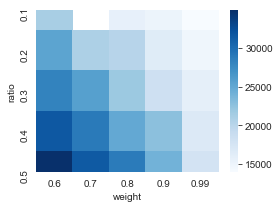

N-t2d150.02


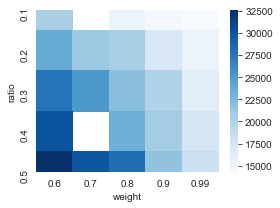

kra32.dat


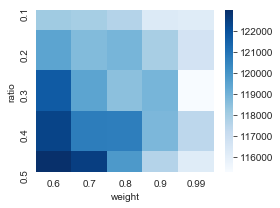

nug12.dat


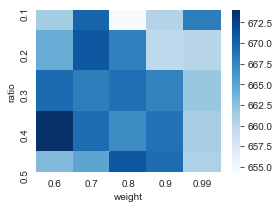

nug30.dat


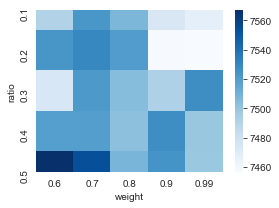

rec05


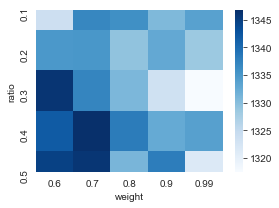

rec13


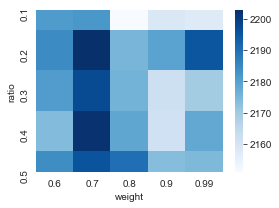

rec19


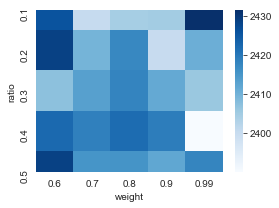

rec31


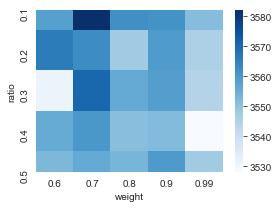

tho30.dat


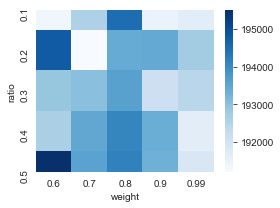

In [2]:
df = pd.read_csv('results/results.csv',index_col=0)
df.columns = [c if c!='min' else 'best' for c in df.columns]
df = pd.pivot_table(df,index=['filename','ratio','weight'],values='best',aggfunc={np.mean,np.min, np.std})#.reset_index()
df.columns = ['best_'+ c for c in df.columns]
dfres = df.reset_index()
dfres
for instance_name in dfres.filename.drop_duplicates().values:
  print(instance_name, )
  plt.figure(figsize=(4,3))
  sns.set_style("whitegrid")
  square = dfres[dfres.filename == instance_name].pivot_table(index='ratio', columns='weight', values='best_mean')
  sns.heatmap(square, cmap="Blues")
  plt.tight_layout()
  plt.savefig('img/heatmap_'+instance_name+'.pdf')

  plt.show()

## Compare CEGO and UMM

Execute this cell to load results.
(???) primrtoo QAP y PFSF, que hay de los dos y despues LOP, solo hay UMM (???)

In [3]:
lis = []
for folder in ['results-loplib/', 'results/']  : 
  for filename in os.listdir(folder) :
    if 'pkl'in filename:
      lis.append(pd.read_pickle(folder+filename))
dfcego = pd.concat(lis)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl.gz'in filename])
dfumm['instance'] = dfumm['instance'].str[2:] #para quitar el punto barrra

#### Generate plots (this will take a while)

Instance:  N-t1d100.01


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


Saving to img/fitness_real_lop_RandA1_N-t1d100_01.pdf
Instance:  N-t1d100.02
Saving to img/fitness_real_lop_RandA1_N-t1d100_02.pdf
Instance:  N-t1d150.01
Saving to img/fitness_real_lop_RandA1_N-t1d150_01.pdf
Instance:  N-t1d150.02
Saving to img/fitness_real_lop_RandA1_N-t1d150_02.pdf
Instance:  N-t1d200.01
Saving to img/fitness_real_lop_RandA1_N-t1d200_01.pdf
Instance:  N-t1d200.02
Saving to img/fitness_real_lop_RandA1_N-t1d200_02.pdf
Instance:  N-t2d150.01
Saving to img/fitness_real_lop_RandA2_N-t2d150_01.pdf
Instance:  N-t2d150.02
Saving to img/fitness_real_lop_RandA2_N-t2d150_02.pdf
Instance:  N-t2d200.01
Saving to img/fitness_real_lop_RandA2_N-t2d200_01.pdf
Instance:  N-t2d200.02
Saving to img/fitness_real_lop_RandA2_N-t2d200_02.pdf
Instance:  N-p50-01
Saving to img/fitness_real_lop_RandB_N-p50-01.pdf
Instance:  N-p50-02
Saving to img/fitness_real_lop_RandB_N-p50-02.pdf
Instance:  N-be75eec_150
Saving to img/fitness_real_lop_xLOLIB_N-be75eec_150.pdf
Instance:  N-be75np_150
Saving t

/home/manu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Saving to img/fitness_real_qap_nug30_dat.pdf
Instance:  nug12
Saving to img/fitness_real_qap_nug12_dat.pdf
Instance:  rec05
Saving to img/fitness_real_pfsp_rec05_txt.pdf
Instance:  rec13
Saving to img/fitness_real_pfsp_rec13_txt.pdf
Instance:  rec19
Saving to img/fitness_real_pfsp_rec19_txt.pdf
Instance:  rec31
Saving to img/fitness_real_pfsp_rec31_txt.pdf


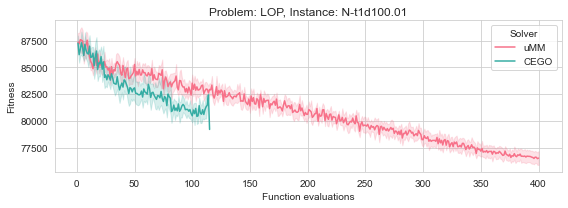

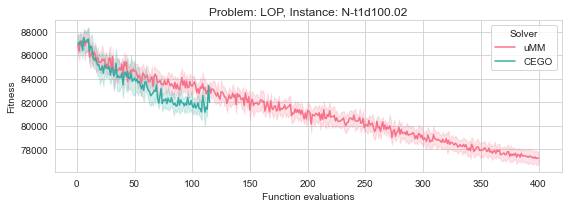

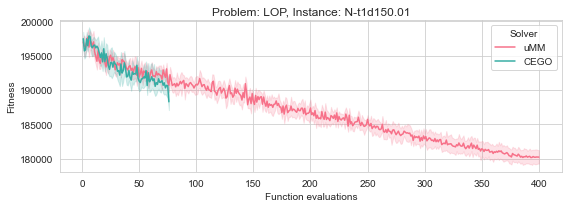

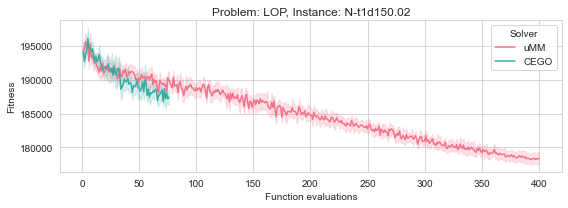

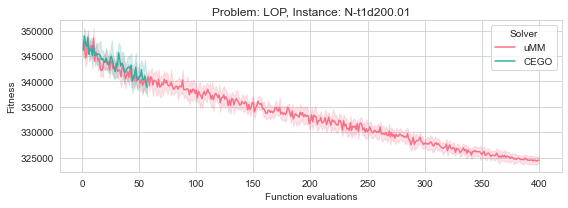

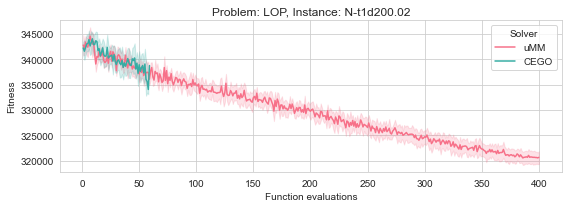

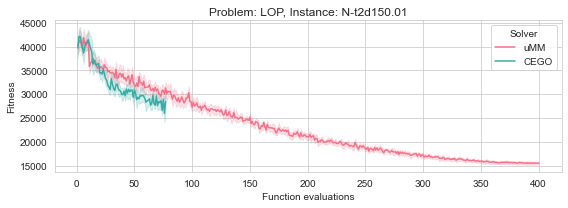

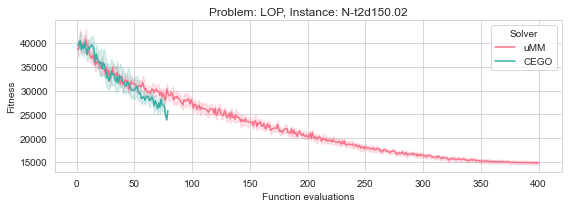

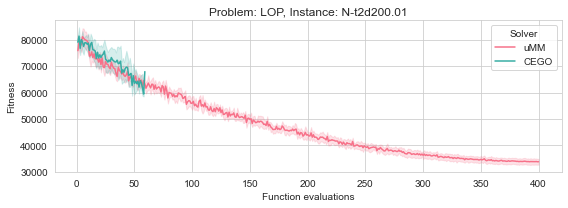

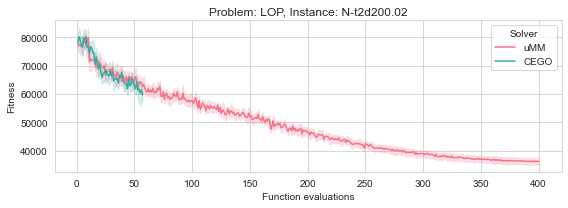

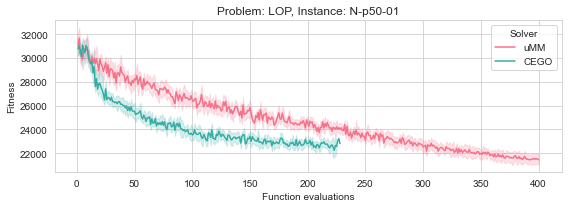

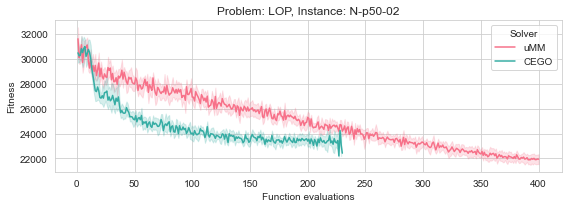

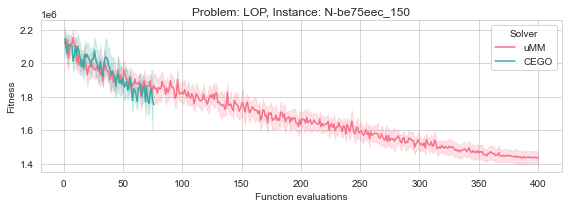

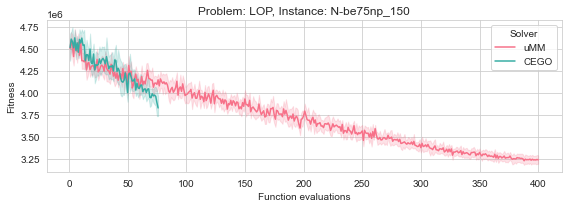

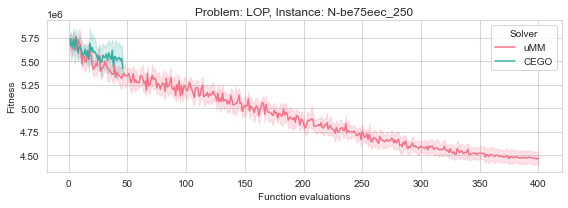

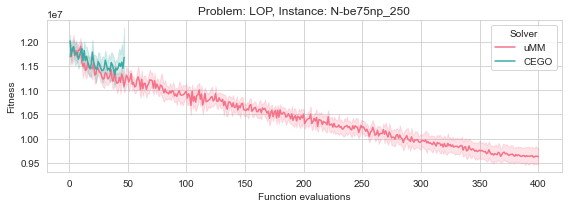

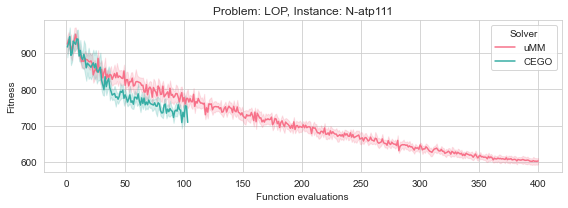

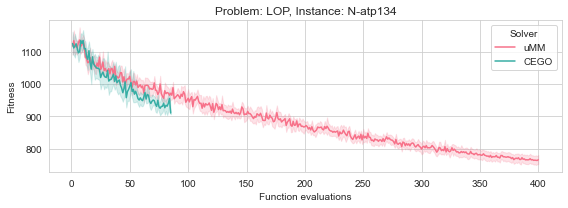

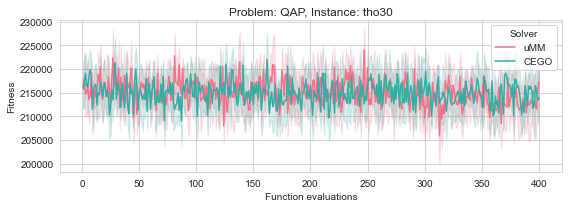

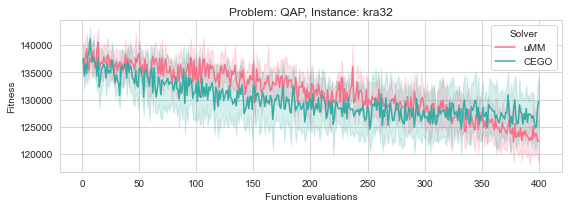

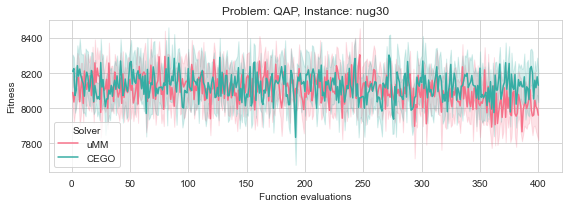

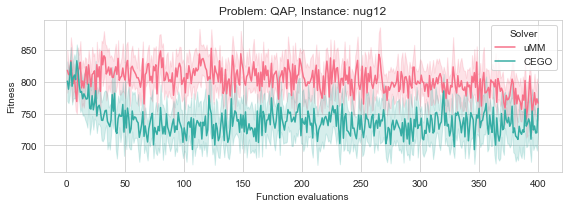

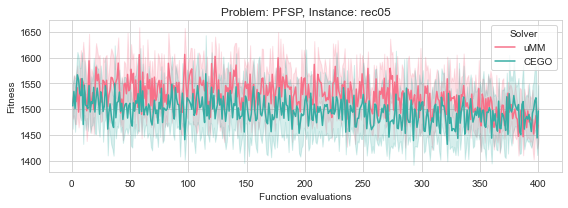

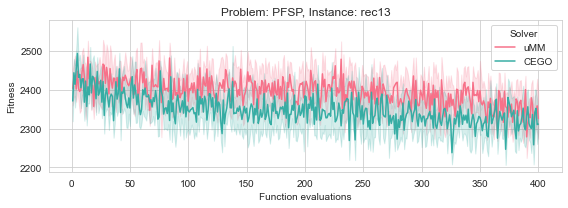

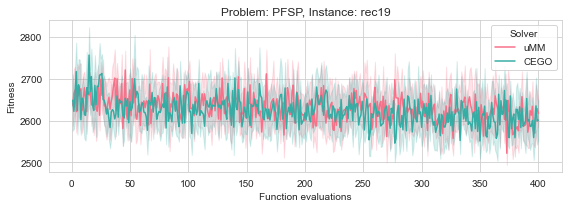

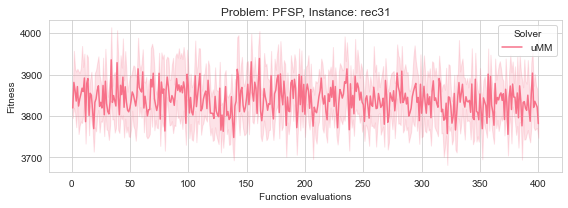

In [4]:
sns.set_style("whitegrid") # MANU: Should we move this configuration option to the top cell?
dfselected = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
dfselected
for inst in dfselected.instance_name.values:
  print("Instance: ", inst)
  df = pd.concat([dfumm[dfumm.instance.str.contains(inst)], dfcego[dfcego.instance.str.contains(inst)]],sort=False)
  if len(df) > 0:
    plt.figure(figsize=(8,3))
    palette = sns.color_palette("husl", len(df['Solver'].drop_duplicates()))
    g = sns.lineplot(x='Function evaluations',y='Fitness',hue='Solver',data=df, palette=palette)
    g.set_title('Problem: '+df.Problem.iloc[0]+', Instance: '+ inst)
    plt.tight_layout()
    filename = 'img/fitness_real_'+df.instance.iloc[0].replace('/','_').replace('.','_')+'.pdf'
    print("Saving to " + filename)
    plt.savefig(filename)
    plt.show()


ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM '
 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


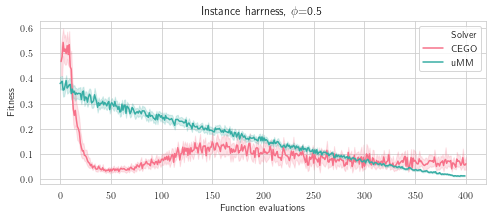

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM '
 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


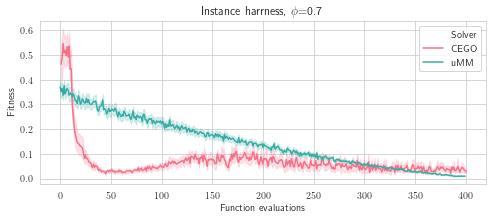

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'CEGO' 'uMM '
 'CEGO' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


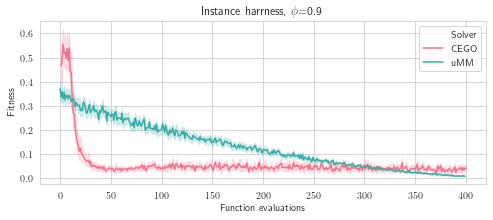

In [17]:
# COmpare in synthetic data
# Compare the convergence to lowest fitness funtion values by the two solvers
dfcego = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(9,12) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename],sort=False)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl'in filename and 'pick' in filename and 'pickCEGO.pkl' not in filename],sort=False)
dfumm.columns = [c if c!= 'Sample size' else 'Function evaluations' for c in dfumm.columns]
dfumm.columns = [c if c!= 'rep' else 'seed' for c in dfumm.columns]
for phi in [0.5, 0.7, 0.9]: 
  df = pd.concat([dfcego[dfcego.instance.str.contains('phi='+str(phi))], dfumm[dfumm.phi_instance==phi]],sort=False)
  sns.set_style("whitegrid")
  print("ranking of the solvers by fitness")
  print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
  color_variable = 'Solver'
  y_variables = ['Fitness']#,'Distance','phi_sample'
  palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
  for y_variable in y_variables:
      plt.figure(figsize=(8,3))
      g = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
      g.set_title(r'Instance harrness, $\phi$='+str(phi))
      plt.savefig('img/fitness_phi_'+str(phi)+'.jpg')
      plt.show()


### Generate combined plot for synthetic LOP

0    NaN
0    0.5
Name: phi_instance, dtype: float64 8000 4000 4000
0    NaN
0    0.7
Name: phi_instance, dtype: float64 8000 4000 4000
0    NaN
0    0.9
Name: phi_instance, dtype: float64 8000 4000 4000
ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM ' 'CEGO' 'uMM ' 'uMM ' 'CEGO'
 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'uMM ']


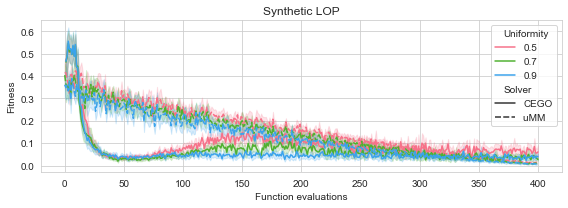

In [6]:
# COmpare in synthetic data in the same plot
# Compare the convergence to lowest fitness funtion values by the two solvers

dfcego = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(9,12) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename],sort=False)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl'in filename and 'pick' in filename and 'pickCEGO.pkl' not in filename],sort=False)
dfumm.columns = [c if c!= 'Sample size' else 'Function evaluations' for c in dfumm.columns]
dfumm.columns = [c if c!= 'rep' else 'seed' for c in dfumm.columns]

lis = []
for phi in [0.5, 0.7, 0.9]: 
  a = dfcego[dfcego.instance.str.contains('phi='+str(phi))]
  b = dfumm[(dfumm.phi_instance==phi) & (dfumm.ratio_samples_learn==0.1503) & (dfumm.weight_mass_learn==0.8362)]
  df = pd.concat([a,b ],sort=False)
  df['Uniformity'] = phi
  print(df.phi_instance.drop_duplicates(), len(df), len(a), len(b))
  lis.append(df)
  
df = pd.concat(lis)

sns.set_style("whitegrid")
print("ranking of the solvers by fitness")
print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
color_variable = 'Uniformity'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(8,3))
    g = sns.lineplot(x='Function evaluations',y=y_variable,style='Solver', hue=color_variable,data=df, palette=palette)
    g.set_title('Synthetic LOP')
    plt.tight_layout()
    plt.savefig('img/synthetic_LOP_combined.pdf')
    plt.show()


### Compare in the mean of min along each repetition tiempos de ejec, intervalos de confianza (Spanglish???) 

This requires executing the cell above to


In [1]:
# tiempo medio y num medio de evaluaciones
a = dfcego.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
a['run_time'] = (a['run_time']/3600).round(1)
a.columns = ['Problem','instance','CEGO Runtime']
b = dfumm.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
b['run_time'] = (b['run_time']/3600).round(1)
b.columns = ['Problem','instance','UMM Runtime']
dftime = pd.merge(b,a)
a = dfcego.groupby(['Problem','instance','seed']).max()['Function evaluations'].groupby(['Problem','instance']).mean().reset_index()
a.columns = ['Problem','instance','CEGO F. evaluations']
dftime = pd.merge(dftime,a)
a = dfcego.groupby(['Problem','instance','seed']).Fitness.min()
b = dfumm.groupby(['Problem','instance','seed']).Fitness.min()
aa = a.groupby(['Problem','instance']).agg(Fitness_CEGO_mean='mean', Fitness_CEGO_std='std').reset_index() 
bb = b.groupby(['Problem','instance']).agg(Fitness_UMM_mean='mean', Fitness_UMM_std='std').reset_index() 
df = pd.merge(aa,bb)
aa = a.reset_index()
bb = b.reset_index()
for inst in df.instance:
  x,y = aa[aa.instance==inst].Fitness.values,bb[bb.instance==inst].Fitness.values
  cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
  df.loc[df.instance==inst,'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))
df['CEGO fitness'] = df.Fitness_CEGO_mean.round(1).astype(str)+" ("+df.Fitness_CEGO_std.round(1).astype(str)+")"
df['UMM fitness'] = df.Fitness_UMM_mean.round(1).astype(str)+" ("+df.Fitness_UMM_std.round(1).astype(str)+")"
df = df.drop(['Fitness_CEGO_mean'	,'Fitness_CEGO_std',	'Fitness_UMM_mean',	'Fitness_UMM_std'], axis=1)
df = pd.merge(df,dftime, on=['Problem', 'instance'])
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df = df[['Problem', 'Instance','UMM fitness', 'CEGO fitness',	'Confidence interval',	'UMM Runtime',	'CEGO Runtime',	'CEGO F. evaluations']]
df


NameError: name 'dfcego' is not defined

In [ ]:
print(df.to_latex(index=False))